<a href="https://colab.research.google.com/github/Molten-Ice/de-identification/blob/colab/dev-notebooks/17-decent-predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#check which GPU is being used:
!nvidia-smi

Sat Apr 29 00:08:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone -b main --single-branch https://github.com/Molten-Ice/de-identification.git
!pip install -r de-identification/requirements.txt
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git /content/stylegan2-ada-pytorch
!wget -P /content/ https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
!python de-identification/setup.py

#Sample image
!wget https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/16070.jpg

Cloning into 'de-identification'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 342 (delta 52), reused 30 (delta 6), pack-reused 203
Receiving objects: 100% (342/342), 335.70 MiB | 18.57 MiB/s, done.
Resolving deltas: 100% (116/116), done.
Updating files: 100% (82/82), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!wget https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/facial-img-1.jpg

--2023-04-29 00:11:03--  https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/facial-img-1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61411 (60K) [image/jpeg]
Saving to: ‘facial-img-1.jpg’

facial-img-1.jpg    100%[===================>]  59.97K  --.-KB/s    in 0.002s  

2023-04-29 00:11:03 (34.8 MB/s) - ‘facial-img-1.jpg’ saved [61411/61411]



G parameters: 30,370,060 | D Parameters: 29,012,513


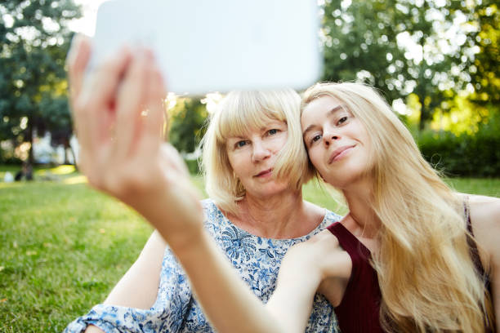

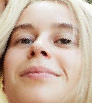

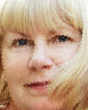

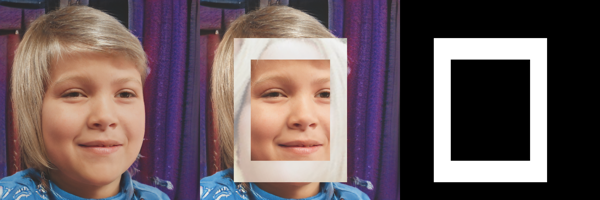

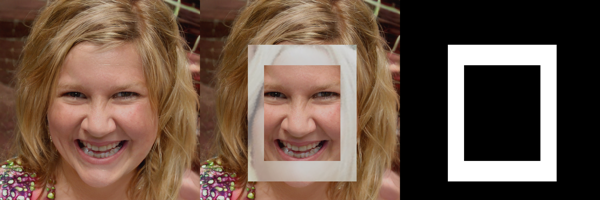

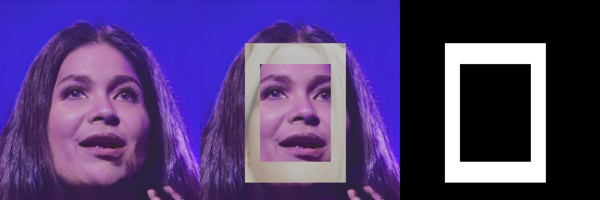

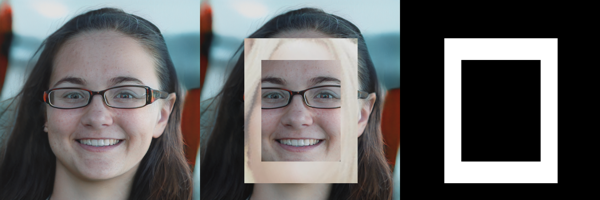

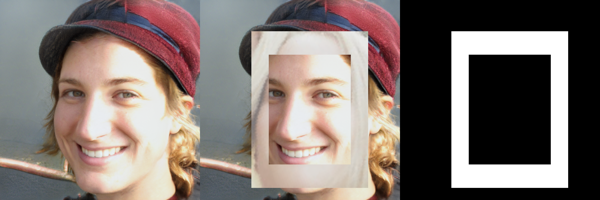

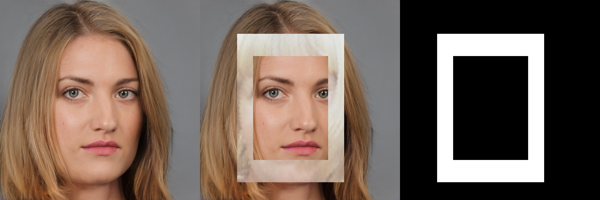

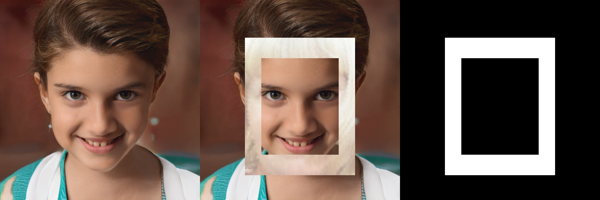

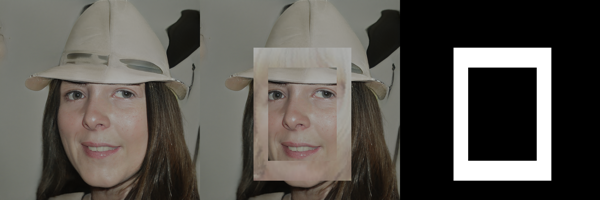

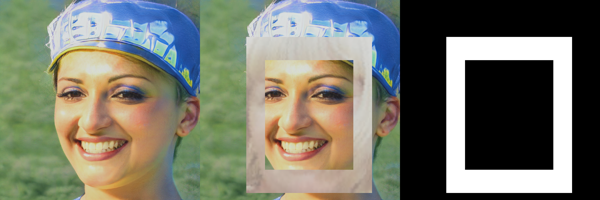

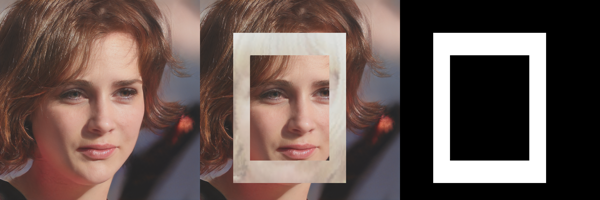

Losses, 0 iteration:: Complete:1.5166, contextual:1.5168,  perceptual original: -0.4321, perceptual (after x0.0005): -0.0002 ,, time: 0.37s
Losses, 200 iteration:: Complete:0.2595, contextual:0.2614,  perceptual original: -3.7504, perceptual (after x0.0005): -0.0019 ,, time: 50.27s
Losses, 400 iteration:: Complete:0.2156, contextual:0.2201,  perceptual original: -9.1580, perceptual (after x0.0005): -0.0046 ,, time: 100.23s
Losses, 600 iteration:: Complete:0.2067, contextual:0.2119,  perceptual original: -10.4497, perceptual (after x0.0005): -0.0052 ,, time: 150.20s
Generation finished for 10 in 199.78 seconds


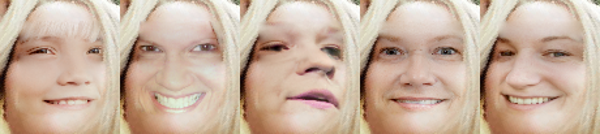

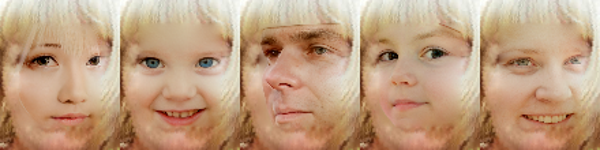

In [5]:
import sys
sys.path.insert(1, '/content/de-identification/')
from engine import *

image_filepath = '16070.jpg'
# image_filepath = 'facial-img-1.jpg'

border_factor = 0.15

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
assert device.type == "cuda", "Error, not running on gpu!"

with open('ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  
with open('ffhq.pkl', 'rb') as f:
    D = pickle.load(f)['D'].to(device) 
print(f"G parameters: {sum(p.numel() for p in G.parameters()):,} | D Parameters: {sum(p.numel() for p in D.parameters()):,}")

# Load MTCNN face detection model
mtcnn = MTCNN(keep_all=True, device=device) #loading face detection model

#  Load image using cv2
original_img = cv2.imread(image_filepath)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
display(ImageOps.contain(Image.fromarray(original_img), (500, 500)))

#finds boxes, landmarks using original image
raw_boxes, raw_landmarks, probs = generate_boxes_landmarks(original_img, mtcnn, device)

# generate gender, race and age for faces in image
face_traits = generate_face_traits(original_img, raw_boxes)

# padding added to image (so rotation does not crop content)
pad_width = max(original_img.shape[:2])//2

# generated detected faces after alignment
cropped_faces = generate_align_rotated_faces(mtcnn, original_img, raw_boxes, raw_landmarks, pad_width, device) 

# display generated faces found (not necessary):
for face in [array[0].copy() for array in cropped_faces]:
    display(Image.fromarray(face))

### Inpainting faces ###

training_images, indexes = generate_training_image(mtcnn, G, cropped_faces, face_traits, border_factor, device, samples_wanted = 5)

# display training_images faces found (not necessary):
for z, box, real_face_tensor, mask, _ in training_images:
    img = G(z, None) 
    display(display_and_concat([img, real_face_tensor*mask + img*(1-mask), mask], size = (600, 600)))

torch.cuda.empty_cache()
fake_faces, fixed_noise, progress = train_loop(G, D, training_images, track_progress = 50, eval_interval = 200)

# Display pre-poisson blended predictions(not necessary)
# for index in indexes:
#     print("Generations for different face:")
#     for z_idx in range(*index):
#         z, box, real_face_tensor, mask, _ = training_images[z_idx]
#         img = G(z, None) 
#         generated_face = fake_faces[z_idx].unsqueeze(dim=0)
#         display(display_and_concat([real_face_tensor*mask + img*(1-mask), real_face_tensor*mask + generated_face*(1-mask)], size = (600, 600)))

generated_faces = poisson_blend_generated_faces(G, training_images, fake_faces, indexes, border_factor)

### Placing inpainting predictions back in original image ###
for list_of_faces in generated_faces:
    display(ImageOps.contain(Image.fromarray(np.concatenate(list_of_faces,axis=1)), (600, 600)))

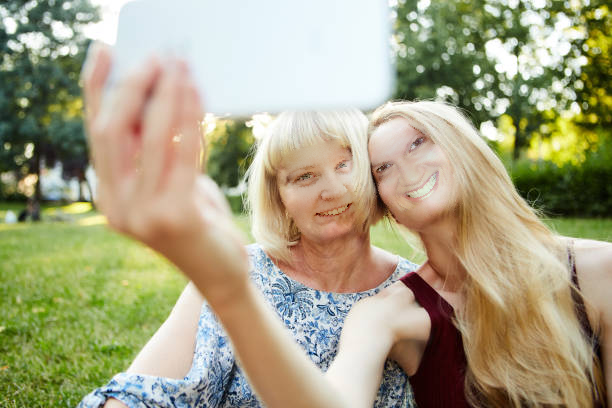

In [7]:
picked_faces = [generated_faces[0][1], generated_faces[1][4]]

output_img_padded = np.zeros([original_img.shape[0]+2*pad_width, original_img.shape[1]+2*pad_width, 3], dtype = original_img.dtype)
output_img_padded[pad_width:-pad_width, pad_width:-pad_width] = original_img.copy()
# display(ImageOps.contain(Image.fromarray(output_img_padded), (500, 500)))

for generated_face, (_, box, rotated_box, rotated_img, rotate_angle, face_centre) in zip(picked_faces, cropped_faces):
    #place generated image on rotated image

    rotated_img = rotated_img.copy()
    rotated_img[rotated_box[1]:rotated_box[3], rotated_box[0]:rotated_box[2]] = generated_face
    #rotate back to original alignment
    rotated_img = np.array(Image.fromarray(rotated_img).rotate(-rotate_angle, center=face_centre, expand=False))
    #place generated poisson blended, rotated face back onto original image
    output_img_padded[box[1]:box[3], box[0]:box[2]] = rotated_img[box[1]:box[3], box[0]:box[2]]

output_img = output_img_padded[pad_width:-pad_width, pad_width:-pad_width]
display(Image.fromarray(output_img))